# Constants

In [ ]:
DROPPED_LEXICAL_COLUMNS = ['Swear', 'Numbers', 'Inhibition', 'Preceptual','Anxiety', 'Anger', 'Sadness', 'Work', 'Articles',]
DROPPED_FACIAL_COLUMNS = [
'average_inner_brow_height_max' , 'average_inner_brow_height_median', 'average_inner_brow_height_min',
'average_outer_brow_height_max', 	'average_outer_brow_height_median', 	'average_outer_brow_height_min',
'eye_open_max', 'eye_open_median', 'eye_open_min',
'inner_lip_height_max', 'inner_lip_height_median', 'inner_lip_height_min',
'lip_corner_distance_max', 'lip_corner_distance_median', 'lip_corner_distance_min',
'outer_lip_height_max', 'outer_lip_height_median', 'outer_lip_height_min',
'smile_max', 'smile_median', 'smile_min',
'pitch_max', 'pitch_median', 'pitch_min',
'roll_max', 'roll_median', 'roll_min',
'yaw_max', 'yaw_median', 'yaw_min'
                           ] 
DROPPED_PROSODIC_COLUMNS = []
TARGET_COLUMN = 'RecommendHiring'

# Data Preprocessing

## Import Datasets

In [12]:
import pandas as pd
import os

datasets_folder_path = "../datasets"

features_df = pd.read_csv(os.path.join(datasets_folder_path, 'combined_features.csv'))
features_df = features_df.set_index('participant_id')

labels_df = pd.read_csv(os.path.join(datasets_folder_path, 'turker_scores_full_interview.csv'))
labels_df = labels_df.set_index('Participant')
labels_df = labels_df.loc[labels_df['Worker'] == 'AGGR']

features_df.index = features_df.index.str.lower()
labels_df.index = labels_df.index.str.lower()
indexed_combined_df = features_df.join(labels_df[[TARGET_COLUMN]], how='left')

## Fill NaN Values

In [13]:
print(indexed_combined_df.isna().sum().sum())
indexed_combined_df.fillna(indexed_combined_df.mean(), inplace=True)
print(indexed_combined_df.isna().sum().sum())

16
0


## Drop Unnecessary Columns

In [14]:
indexed_combined_df = indexed_combined_df.drop(columns=DROPPED_FACIAL_COLUMNS + DROPPED_LEXICAL_COLUMNS + DROPPED_PROSODIC_COLUMNS)
# combined_df = combined_df.reset_index(drop=True)

# Split Data

In [15]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

groups = indexed_combined_df.index.str.extract(r"[Pp]{1,2}(\d+)")[0]
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train_indices, test_indices in gss.split(indexed_combined_df, indexed_combined_df[TARGET_COLUMN], groups):
    train_df = indexed_combined_df.iloc[train_indices]
    test_df = indexed_combined_df.iloc[test_indices]

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test, y_test = test_df.iloc[:, :-1], test_df.iloc[:, -1]

# Feature Scaling

In [16]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))  # fit_transofmr expects a 2D array, so we need to reshape to 2D from 1D.
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Feature Selection

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV

lasso_cv = LassoCV(cv=5, random_state=42, max_iter=20000)
lasso_cv.fit(X_train_scaled, y_train)

coefficients = lasso_cv.coef_
selected_features_indices = np.where(coefficients != 0)[0]

feature_names = list(indexed_combined_df.columns[:-1])
selected_feature_names = [feature_names[i] for i in selected_features_indices]

selected_feature_set = set(selected_features_indices)
unselected_feature_names = [feature_names[i] for i in range(len(feature_names)) if i not in selected_feature_set]

print(f"Remove {len(unselected_feature_names)} features")
print("Unselected features:", unselected_feature_names)
print("Selected features:", selected_feature_names)
print(f"After removal, you'll have {len(selected_feature_names)} features")

X_train_scaled = X_train_scaled[:, selected_features_indices]
X_test_scaled = X_test_scaled[:, selected_features_indices]

Remove 52 features
Unselected features: ['f0_mean', 'f0_min', 'f0_max', 'f0_range', 'intensity_min', 'intensity_max', 'intensity_range', 'intensity_sd', 'f1_mean', 'f1_sd', 'f2_mean', 'f2_sd', 'f3_mean', 'f3_f1_mean', 'f2_f1_sd', 'f3_f1_sd', 'shimmer', 'pause_duration_max', 'pause_duration_avg', 'duration', 'average_outer_brow_height_mean', 'average_inner_brow_height_mean', 'eye_open_mean', 'lip_corner_distance_mean', 'smile_mean', 'pitch_mean', 'yaw_mean', 'average_outer_brow_height_std', 'average_inner_brow_height_std', 'eye_open_std', 'outer_lip_height_std', 'smile_std', 'pitch_std', 'roll_std', 'Total Words', 'Unique Words', 'Filler Words', 'Audio Duration (s)', 'Duration/Unique Words', 'Duration/Filler Words', 'We', 'Non-Fluences', 'PosEmotion', 'NegEmotion', 'Cognitive', 'Relativity', 'Verbs', 'Adverbs', 'Prepositions', 'Conjunctions', 'Negations', 'Quantifiers']
Selected features: ['f0_sd', 'intensity_mean', 'f3_sd', 'f2_f1_mean', 'jitter', 'percent_unvoiced', 'percent_breaks', 

# Train SVR Model

In [19]:
from sklearn.svm import SVR
import numpy as np

svr_regressor = SVR(kernel='rbf')
svr_regressor.fit(X_train_scaled, y_train_scaled)

/Users/bassel27/personal_projects/facial_expressions_detection/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

# Prediction

In [20]:
y_pred_scaled = svr_regressor.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Model Evaluation Metrics

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Training scores
train_pred = scaler_y.inverse_transform(
    svr_regressor.predict(X_train_scaled).reshape(-1, 1)
)
train_r2 = r2_score(y_train, train_pred)

print(
    f"""
=== Model Performance ===
Test Scores:
- MSE: {mse:.3f}
- MAE: {mae:.3f}
- R²: {r2:.3f}
"""
)


=== Model Performance ===
Test Scores:
- MSE: 0.419
- MAE: 0.524
- R²: 0.114



# Visualization

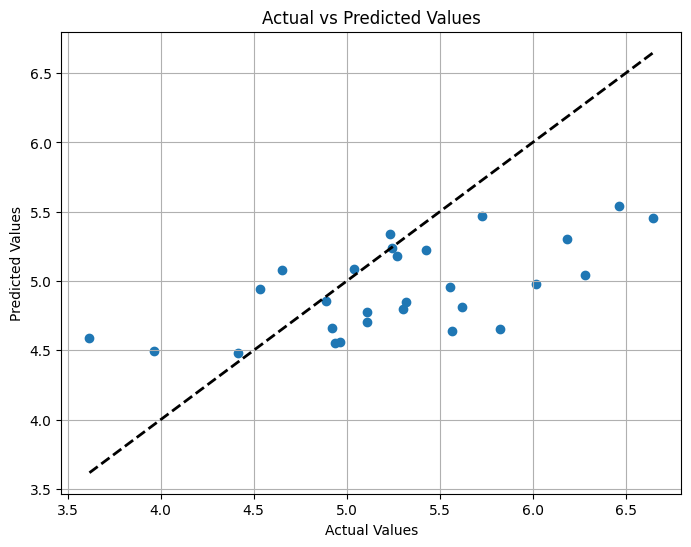

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)    # "k" stands for black (k is the color code for black in Matplotlib). # "--" makes it a dashed line. # lw stands for line width.
	

# Labels and title
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
ax.set_title("Actual vs Predicted Values")
ax.grid(True)

plt.show()